### Importing libraries

In [328]:
library(funFEM)
library(plyr)
library(tidyverse)
library(FactoMineR)
library(factoextra)
library(ggmap)
library(gridExtra)
library(class)
library(RColorBrewer)
library(ggthemes)
library(corrplot)
library(MASS)
library(mclust)
library(caret)
data(velib)

### Preparing data

In [224]:
x <- as.matrix(velib$data)
colnames(x) <- 1:ncol(x)
rownames(x) <- velib$names

bikes <- tibble(velib$data)
bikes$long <- velib$position$longitude
bikes$lat <- velib$position$latitude
bikes$hill <- as.factor(velib$bonus)
bikes$name <- velib$name

fig <- function(width, heigth){
     options(repr.plot.width = width, repr.plot.height = heigth)
}

name_func <- function(name) {
    paste('T', as.numeric(substring(name, first=2))-13, sep='')
}

bikes <- bikes %>% 
    select(!V1:V13) %>%
    rename_with(name_func, V14:V181)



head(bikes)

T1         T2         T3         T4         T5         T6         T7        
1 0.03846154 0.03846154 0.07692308 0.03846154 0.03846154 0.03846154 0.03846154
2 0.47826087 0.47826087 0.47826087 0.43478261 0.43478261 0.43478261 0.43478261
3 0.21818182 0.14545455 0.12727273 0.10909091 0.10909091 0.10909091 0.09090909
4 0.95238095 0.95238095 0.95238095 0.95238095 0.95238095 0.95238095 0.95238095
5 0.92753623 0.81159420 0.73913043 0.72463768 0.72463768 0.72463768 0.72463768
6 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
  T8         T9         T10        ⋯ T163       T164       T165      
1 0.03846154 0.10714286 0.00000000 ⋯ 0.30769231 0.07692308 0.11538462
2 0.43478261 0.26086957 0.04347826 ⋯ 0.04545455 0.17391304 0.17391304
3 0.09090909 0.05454545 0.10909091 ⋯ 0.14814815 0.29629630 0.31481481
4 1.00000000 1.00000000 1.00000000 ⋯ 0.85714286 0.85714286 0.76190476
5 0.72463768 0.75362319 0.97101449 ⋯ 1.00000000 0.81818182 0.63636364
6 0.16666667 0.08333333 0.00000000 ⋯ 0.13043478 0.08695652 0.08695652
  T166       T167      T168      long     lat      hill name                
1 0.07692308 0.1538462 0.1538462 2.377389 48.88630 0     EURYALE DEHAYNIN   
2 0.17391304 0.2608696 0.3913043 2.317591 48.89002 0     LEMERCIER          
3 0.37037037 0.3703704 0.4074074 2.330447 48.85030 0     MEZIERES RENNES    
4 0.76190476 0.7619048 0.7619048 2.271396 48.83373 0     FARMAN             
5 0.71212121 0.6212121 0.5757576 2.366897 48.84589 0     QUAI DE LA RAPEE   
6 0.43478261 0.3913043 0.5217391 2.363335 48.82191 0     CHOISY POINT D'IVRY

In [225]:
x <- as.matrix(velib$data)
colnames(x) <- 1:ncol(x)
rownames(x) <- velib$names
n <- nrow(x)
stations <- 1:n 
dates <- 14:181
x <- x[stations, dates]
colnames(x) <- 1:length(dates)

### Descriptive statistics

In [229]:
days = c('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday')

bikes_long <- bikes %>% pivot_longer(cols=T1:T168, names_to='time', values_to ='loading') %>% 
    mutate(time=as.numeric(substring(time, first=2))-1)

bikes.load_by_day <- bikes_long %>% 
    mutate(day=factor(days[(time %/% 24) + 1], ordered = TRUE, levels=days)) %>%
    mutate(hour=time %% 24) %>%
    group_by(day, hour) %>%
    summarise(mean_load=mean(loading)) %>%
    mutate(usage=100*(1-mean_load))

`summarise()` has grouped output by 'day'. You can override using the `.groups` argument.



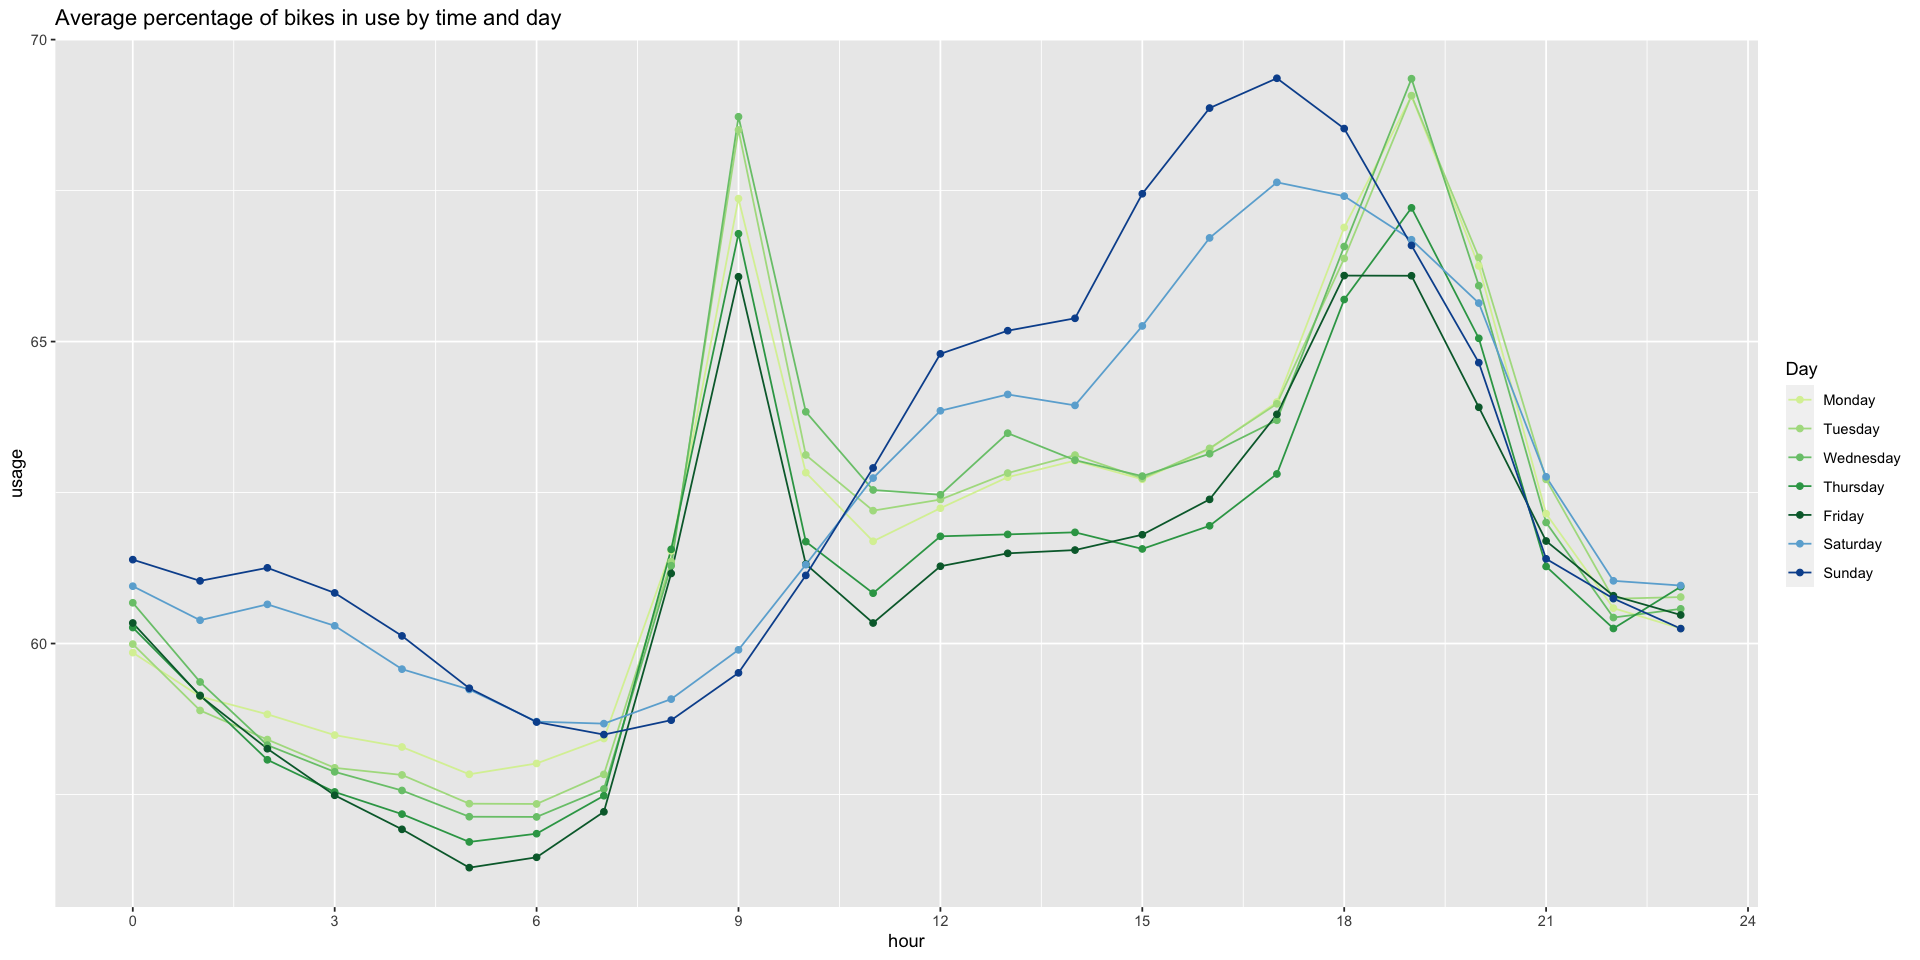

In [230]:
options(repr.plot.width = 16, repr.plot.height = 8)
daycolors <- c(brewer.pal(name='YlGn', 6)[-1], brewer.pal(name='Blues', 9)[c(5,8)])
ggplot(bikes.load_by_day, aes(hour, usage, col=day)) + 
    geom_line() +
    geom_point() +
    scale_x_continuous(breaks = seq(0, 24, by=3)) +
    #scale_y_continuous(limits = c(0.5,0.75)) +
    scale_color_manual(labels=days, values=daycolors) +
    #labs(title='Average loading by time of day', x='hour', y='average loading', color='Day')
    labs(title='Average percentage of bikes in use by time and day', x='hour', y='usage', color='Day')

`summarise()` has grouped output by 'hour'. You can override using the `.groups` argument.

Using zoom = 12...

Using zoom = 12...

Using zoom = 12...



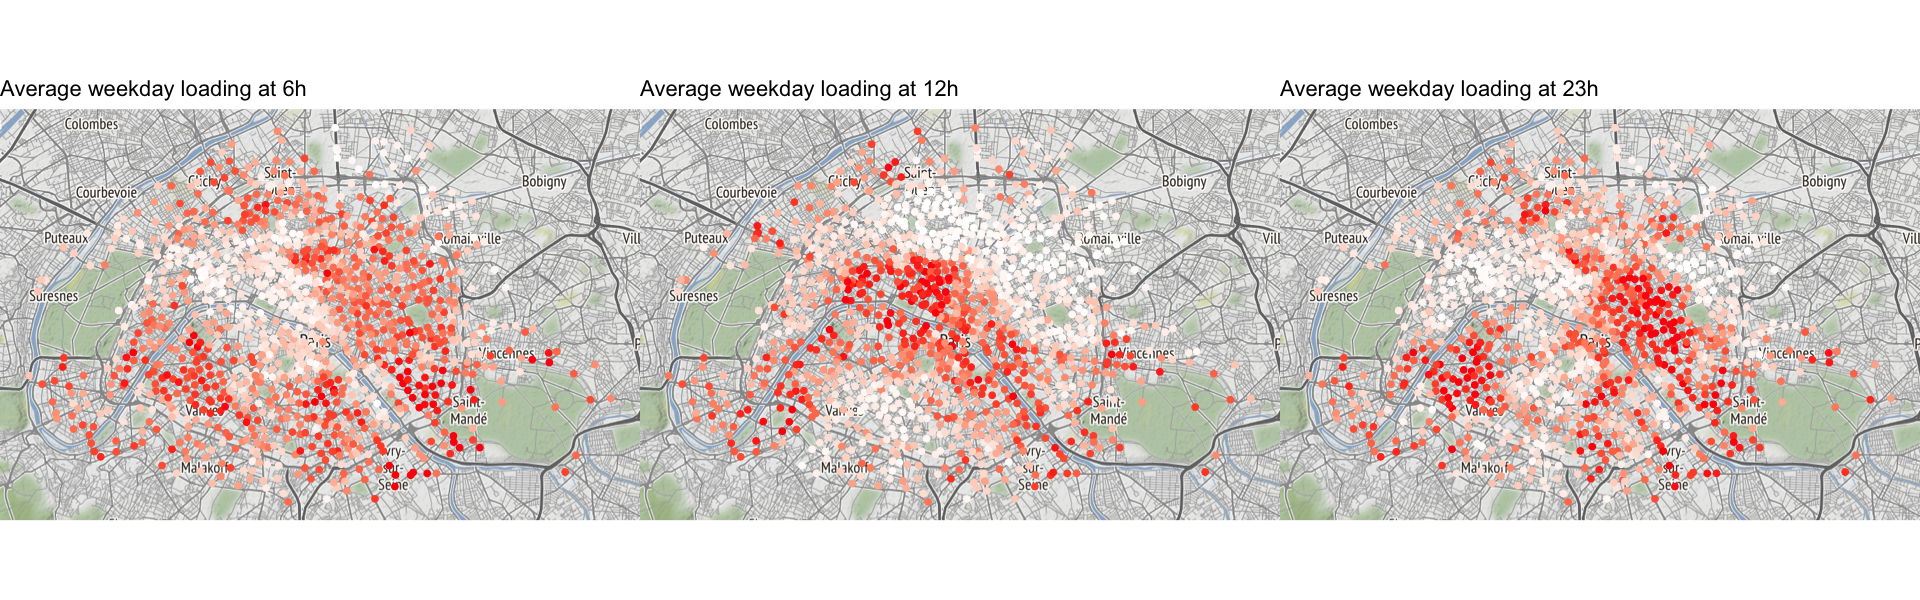

In [231]:
bikes.load_by_hour <- bikes_long %>%
    filter(time < 5*24) %>%
    mutate(hour=time %% 24) %>%
    group_by(hour, name) %>%
    summarise(mean_load=mean(loading)) %>%
    inner_join(bikes %>% select(name, long, lat), by='name')

#bikes.load_by_hour <- bikes_long %>%
#    filter(time < 24) %>%
#    rename(mean_load = loading, hour=time)

options(repr.plot.width = 16, repr.plot.height = 5)

q1 <- qmplot(long, lat, data=bikes.load_by_hour %>% filter(hour==6), col=mean_load) +
    scale_colour_gradient(low='white', high='red', limits=c(0,1)) +
    labs(title='Average weekday loading at 6h') +
    guides(color='none')

q2 <- qmplot(long, lat, data=bikes.load_by_hour %>% filter(hour==12), col=mean_load) +
    scale_colour_gradient(low='white', high='red', limits=c(0,1)) +
    labs(title='Average weekday loading at 12h') +
    guides(color='none')

q3 <- qmplot(long, lat, data=bikes.load_by_hour %>% filter(hour==23), col=mean_load) +
    scale_colour_gradient(low='white', high='red', limits=c(0,1)) +
    labs(title='Average weekday loading at 23h') +
    guides(color='none')

grid.arrange(q1, q2, q3, ncol=3)

### Principal component analysis

In [232]:
res.pca <- PCA(bikes %>% select(T1:T168), ncp=15)
#str(res.pca$eig)

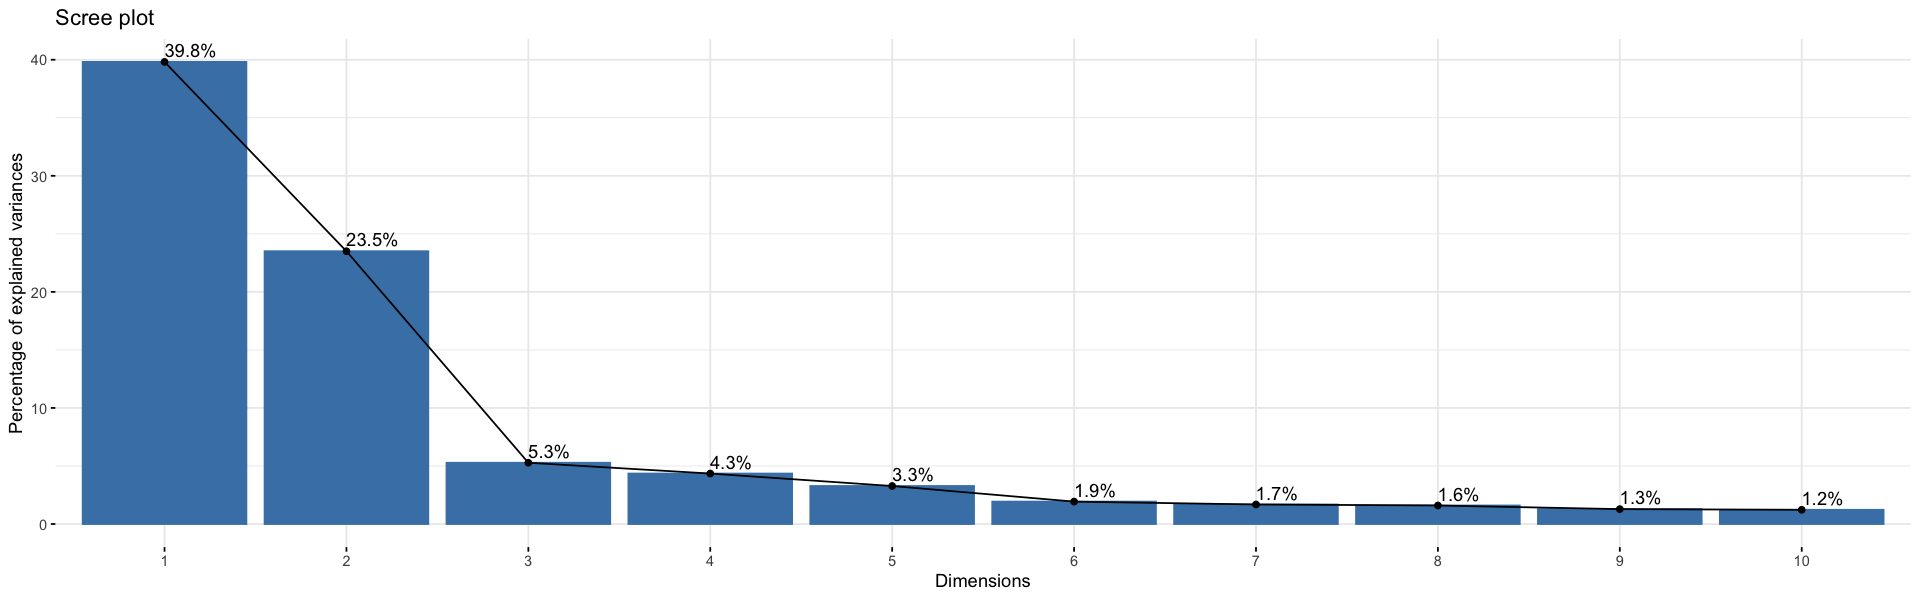

In [233]:
fviz_screeplot(res.pca, ncp=10, addlabels=TRUE)

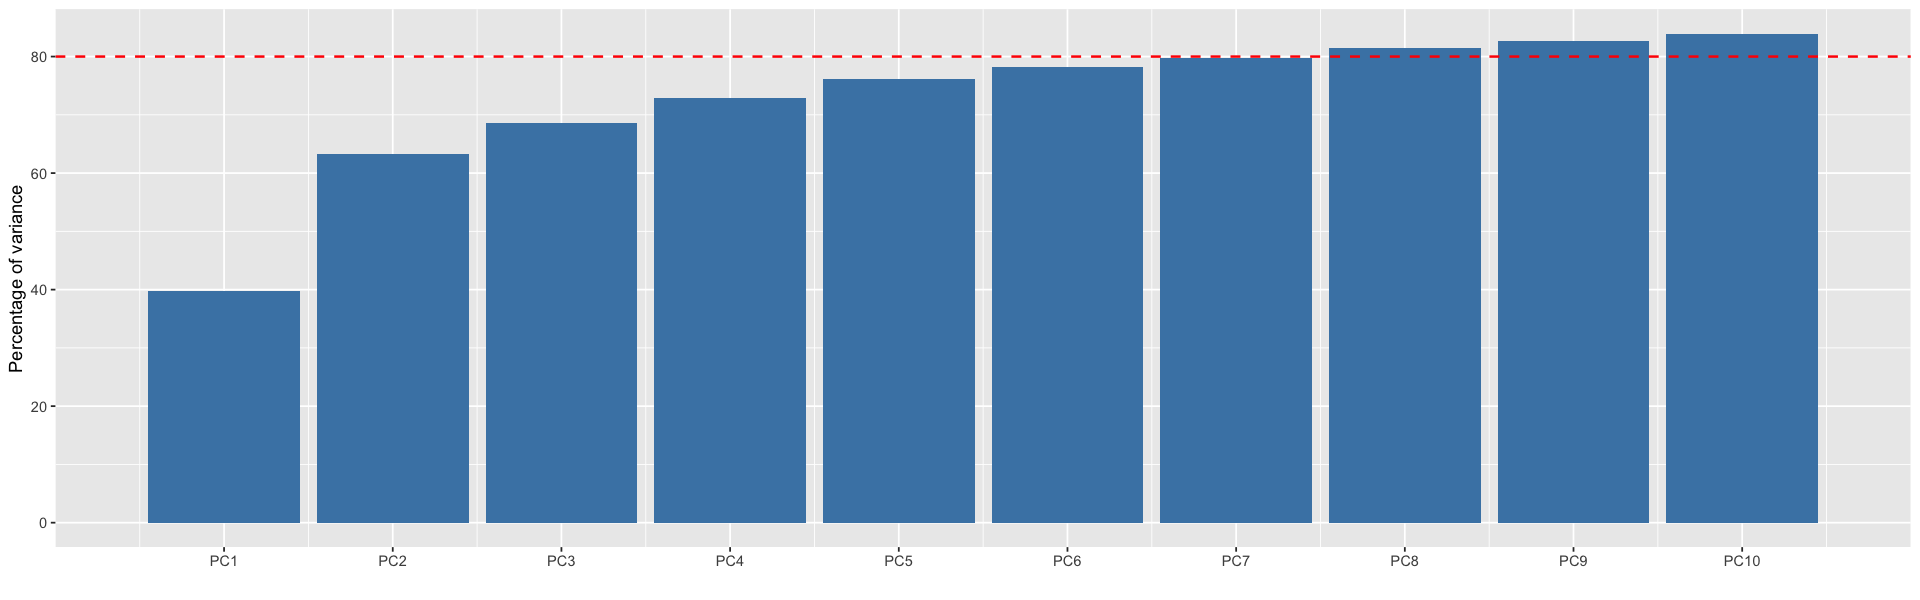

In [234]:
num.pc <- 10
#tot.intertia <- sum(res.pca$eig)
#cum.eig <- cumsum(res.pca$eig[1:num.pc]) / tot.intertia
ggplot() + geom_bar(stat="identity",aes(x=c(1:num.pc), y=res.pca$eig[1:num.pc,3]), fill='#4984B3') +
    labs(x='', y='Percentage of variance') +
    scale_x_continuous(breaks = c(1:num.pc), labels=paste('PC', c(1:num.pc), sep='')) + 
    annotate('segment', x=0, xend=num.pc+1, y=80, yend=80, col='red', linetype=2, size=0.7) +
    coord_cartesian(xlim=c(0.5, num.pc+0.5))

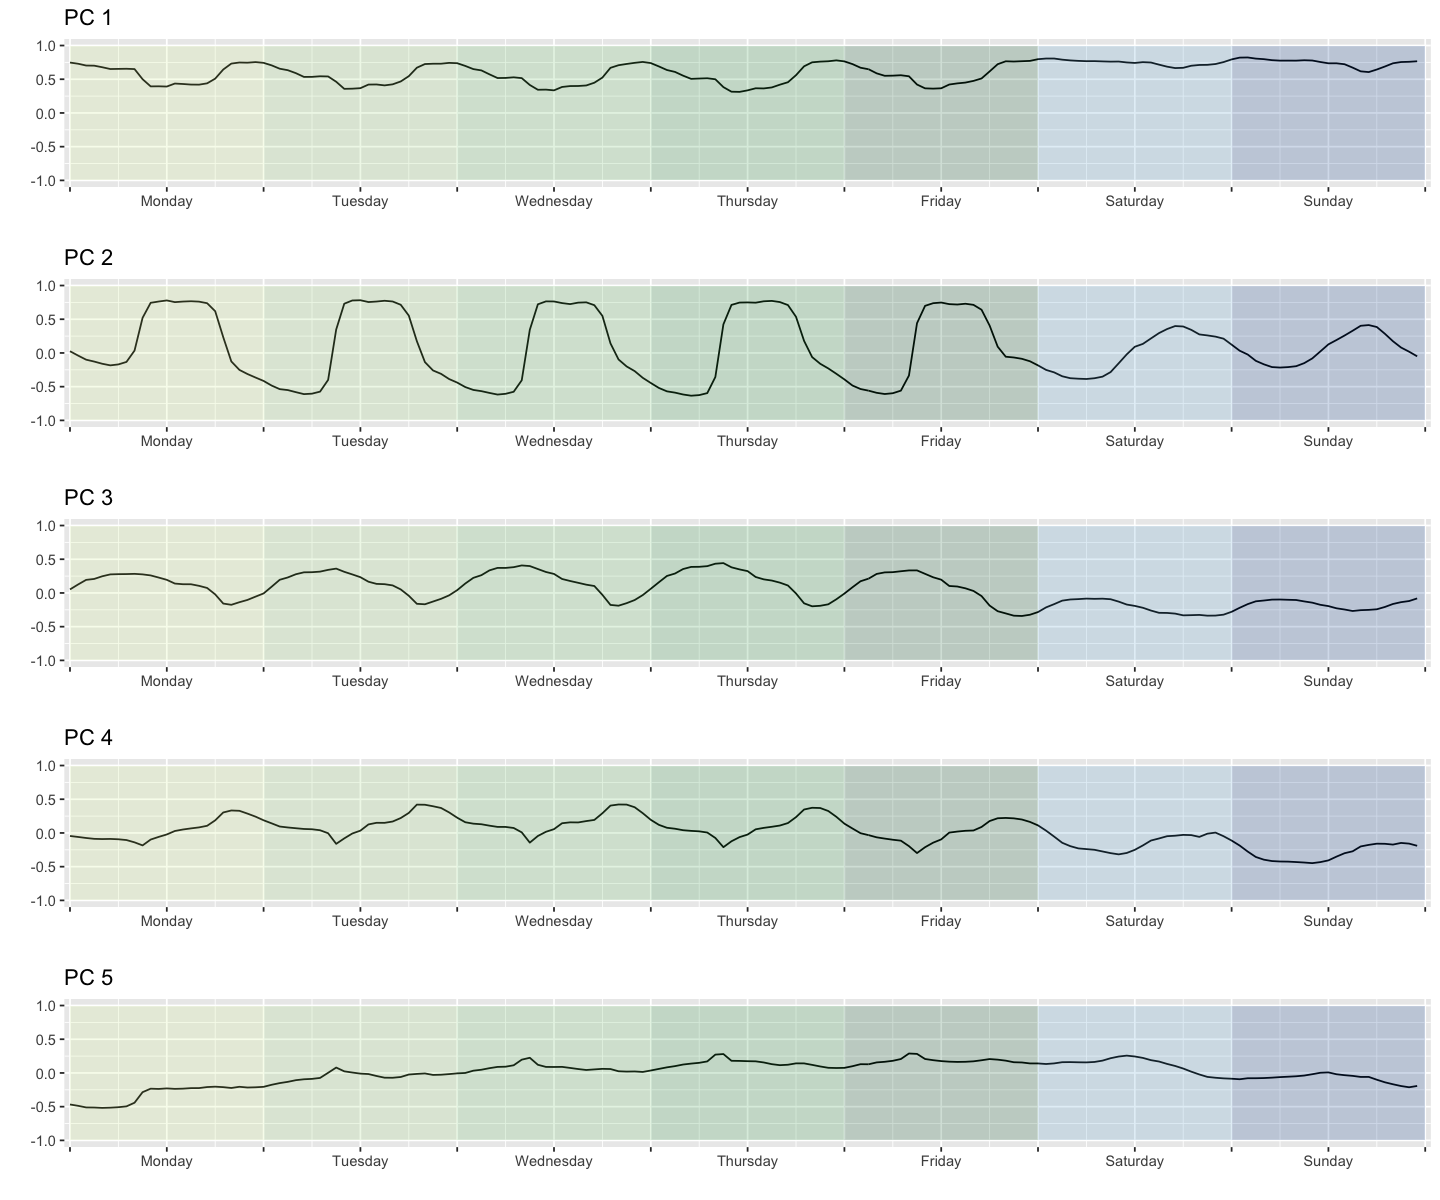

In [355]:
#timeTick <- 1 + 24*(0:6)
#par(mfrow=c(5,1))
#options(repr.plot.width = 15, repr.plot.height = 15)
#for (i in 1:5) {
#    plot(res.pca$var$coord[,i], col = "blue", type = "l",  ylim = c(-1, 1),
#     xlab = "Time", ylab="", main = sprintf("PC%d (%.2f%%)",i, res.pca$eig[i,2]))
#    abline(v = timeTick, lty = "dotted")
#}

day_lab <- rep('', 15)
day_lab[2*c(1:7)] <- days
plot_pc <- function(pc, i) {
    ggplot() + geom_line(aes(c(0:167), pc[,i])) + labs(y='', title=sprintf('PC %d', i)) + 
        scale_y_continuous(name='', limits=c(-1, 1)) + 
        scale_x_continuous(name='', limits=c(0, 168), breaks=12*c(0:14), labels=day_lab) +
        coord_cartesian(xlim=c(7, 161), ylim=c(-1,1)) +
        annotate('rect', xmin = 24*c(0:6), xmax = 24*c(1:7), ymin = rep(-1,7), ymax = rep(1,7), 
                 fill=daycolors, alpha = .2)
        
}

options(repr.plot.width = 12, repr.plot.height = 10)
p1 <- plot_pc(res.pca$var$coord, 1)
p2 <- plot_pc(res.pca$var$coord, 2)
p3 <- plot_pc(res.pca$var$coord, 3)
p4 <- plot_pc(res.pca$var$coord, 4)
p5 <- plot_pc(res.pca$var$coord, 5)
grid.arrange(p1,p2,p3,p4,p5, ncol=1)

In [236]:
bikes.pca <- as_tibble(res.pca$ind$coord) %>%
    select(num_range('Dim.', 1:5)) %>%
    rename_at(vars(paste('Dim.', c(1:5), sep='')), ~ paste('PC', c(1:5), sep=''))

bikes.pca <- bind_cols(bikes %>% select(name, long, lat, hill), bikes.pca)

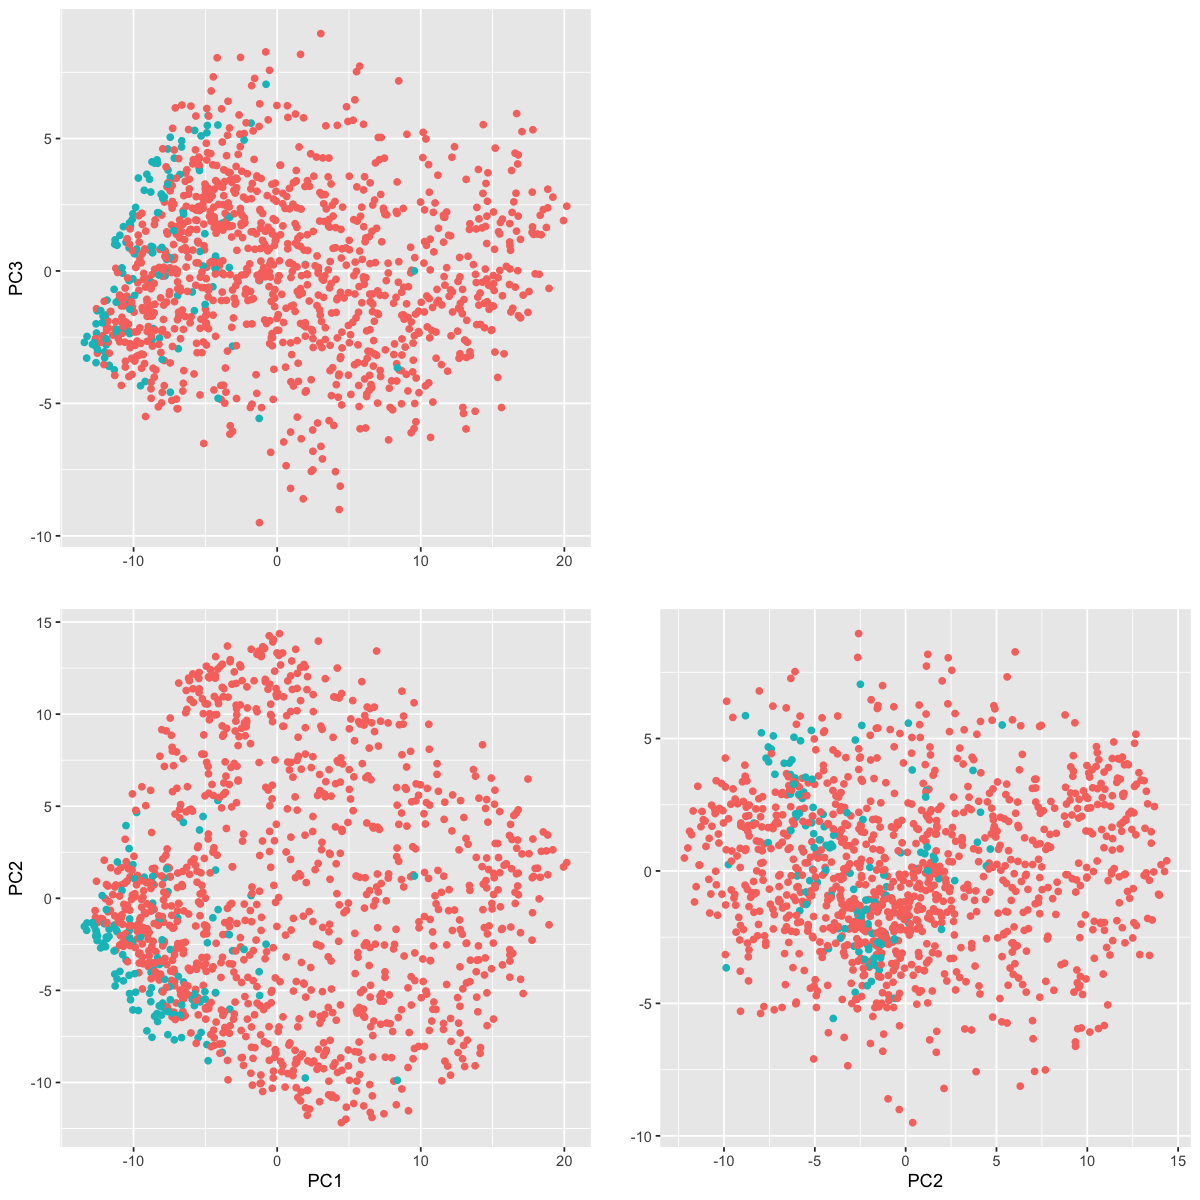

In [237]:
options(repr.plot.width = 10, repr.plot.height = 10)

g <- ggplot(bikes.pca, aes(col=hill)) + 
    guides(color='none')

p1 <- g + geom_point(aes(PC1, PC2)) +
    labs(x='PC1', y='PC2')
p2 <- g + geom_point(aes(PC1, PC3)) +
    labs(x='', y='PC3')
p3 <- g + geom_point(aes(PC2, PC3)) +
    labs(x='PC2', y='')

lay <- rbind(c(2,NA),
             c(1,3))
grid.arrange(p1, p2, p3, layout_matrix = lay)

Using zoom = 12...

Using zoom = 12...

Using zoom = 12...

Using zoom = 12...



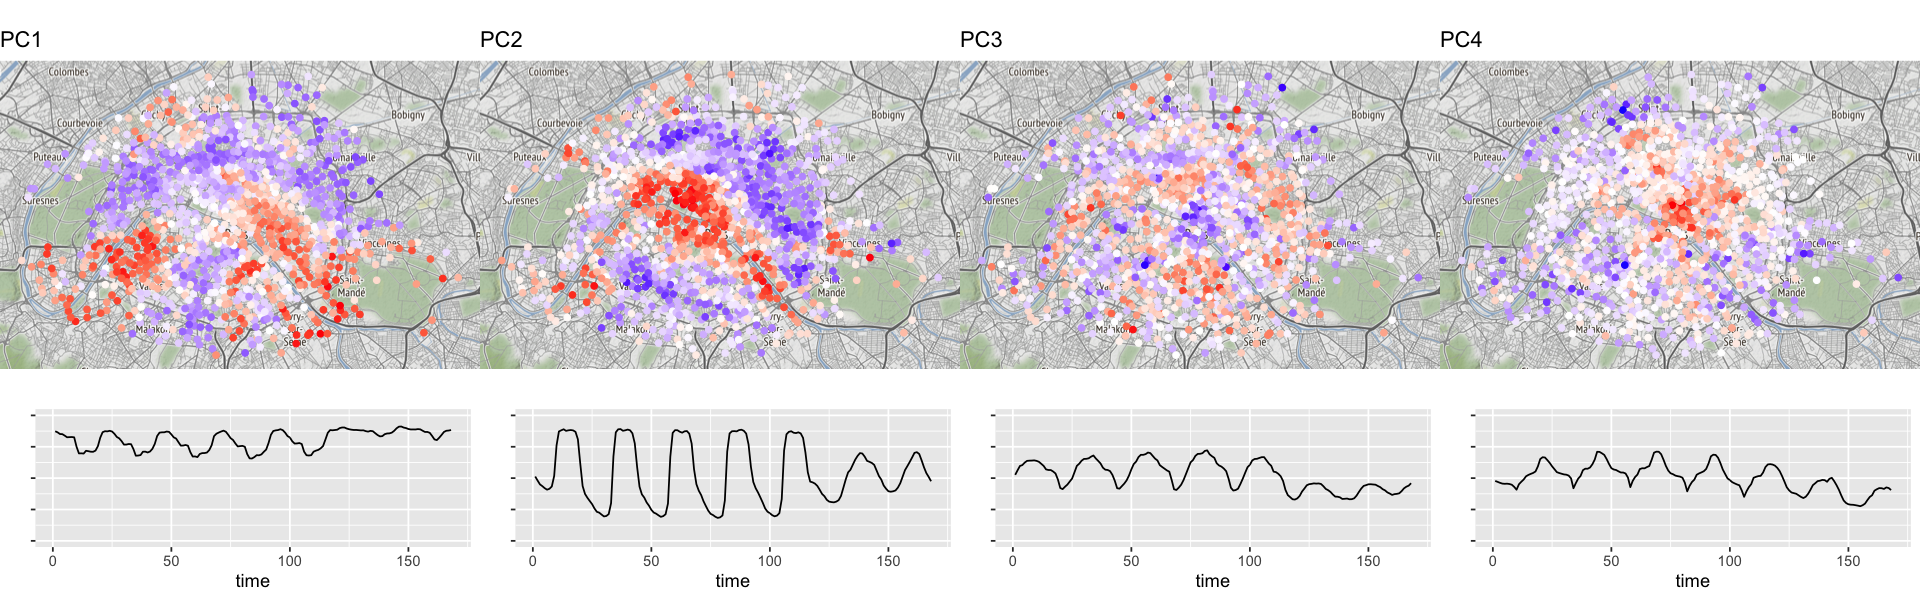

In [51]:
options(repr.plot.width = 16, repr.plot.height = 5)
color_grad <- scale_color_gradient2("Dim1",low = "blue", mid="white", high = "red", midpoint=0)

p1 <- qmplot(long, lat, data=bikes.pca, col=PC1) +
    color_grad + guides(color='none') + labs(title='PC1')
t <- c(1:168)
l1 <- qplot(t, res.pca$var$coord[,1], geom = "line", xlab='time') + 
    scale_y_continuous(name='', labels=NULL, limits=c(-1, 1))

p2 <- qmplot(long, lat, data=bikes.pca, col=PC2) +
    color_grad + guides(color='none') + labs(title='PC2')

l2 <- qplot(t, res.pca$var$coord[,2], geom = "line", xlab='time') + 
    scale_y_continuous(name='', labels=NULL, limits=c(-1, 1))

p3 <- qmplot(long, lat, data=bikes.pca, col=PC3) +
    color_grad + guides(color='none') + labs(title='PC3')

l3 <- qplot(t, res.pca$var$coord[,3], geom = "line", xlab='time') + 
    scale_y_continuous(name='', labels=NULL, limits=c(-1, 1))

p4 <- qmplot(long, lat, data=bikes.pca, col=PC4) +
    color_grad + guides(color='none') + labs(title='PC4')

l4 <- qplot(t, res.pca$var$coord[,4], geom = "line", xlab='time') + 
    scale_y_continuous(name='', labels=NULL, limits=c(-1, 1))
    
#grid.arrange(p1, p2, p3, p4, nrow=2, ncol=2)
layout1 <- rbind(c(1,1,3,3,5,5),
                c(1,1,3,3,5,5),
                c(2,2,4,4,6,6))

layout2 <- rbind(c(1,1,3,3,5,5,7,7),
                c(1,1,3,3,5,5,7,7),
                c(2,2,4,4,6,6,8,8))

layout3 <- rbind(c(1,1,3,3),
                c(1,1,3,3),
                c(2,2,4,4),
                c(5,5,7,7),
                c(5,5,7,7),
                c(6,6,8,8))
grid.arrange(p1, l1, p2, l2, p3, l3, p4, l4, layout_matrix=layout2)

### K-means clustering

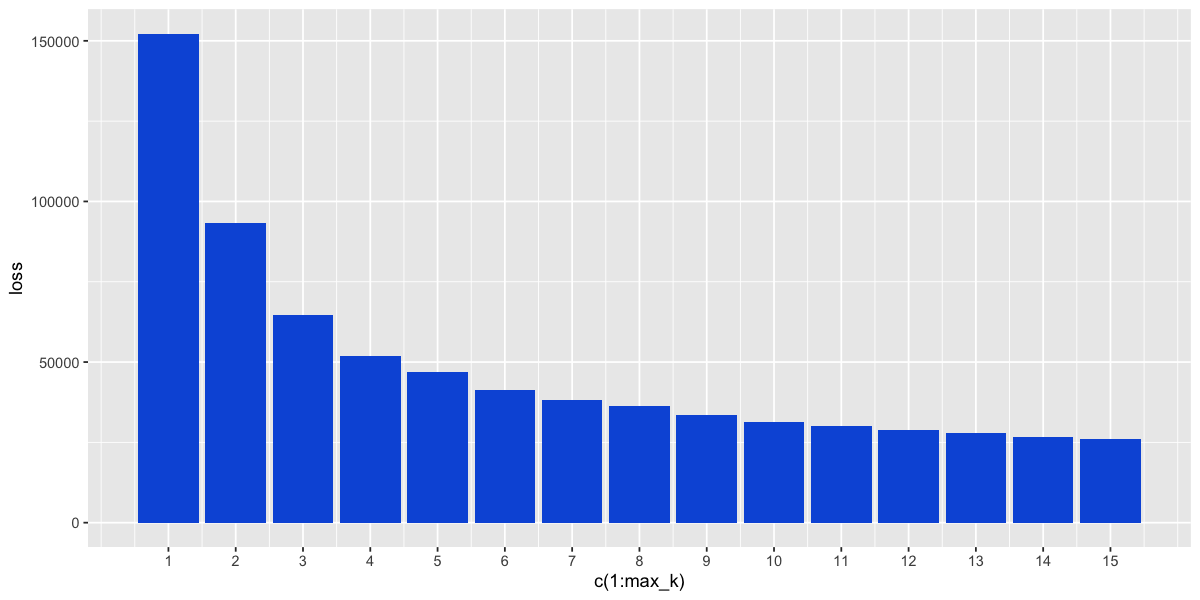

In [110]:
fig(10,5)
max_k <- 15
loss <- vector(length=max_k)
clust.data <- bikes.pca %>% select(PC1:PC5)
for (k in 2:max_k) {
    clust <- kmeans(clust.data, k)
    loss[k] = clust$tot.withinss
}
loss[1] = clust$totss
ggplot() + geom_bar(stat="identity",aes(x=c(1:max_k), y=loss), fill='#0b5bdb') +
    scale_x_continuous(breaks = c(1:max_k))

42 tiles needed, this may take a while (try a smaller zoom).

Source : http://tile.stamen.com/toner/13/4146/2815.png

Source : http://tile.stamen.com/toner/13/4147/2815.png

Source : http://tile.stamen.com/toner/13/4148/2815.png

Source : http://tile.stamen.com/toner/13/4149/2815.png

Source : http://tile.stamen.com/toner/13/4150/2815.png

Source : http://tile.stamen.com/toner/13/4151/2815.png

Source : http://tile.stamen.com/toner/13/4152/2815.png

Source : http://tile.stamen.com/toner/13/4146/2816.png

Source : http://tile.stamen.com/toner/13/4147/2816.png

Source : http://tile.stamen.com/toner/13/4148/2816.png

Source : http://tile.stamen.com/toner/13/4149/2816.png

Source : http://tile.stamen.com/toner/13/4150/2816.png

Source : http://tile.stamen.com/toner/13/4151/2816.png

Source : http://tile.stamen.com/toner/13/4152/2816.png

Source : http://tile.stamen.com/toner/13/4146/2817.png

Source : http://tile.stamen.com/toner/13/4147/2817.png

Source : http://tile.stamen.com/toner/13/4

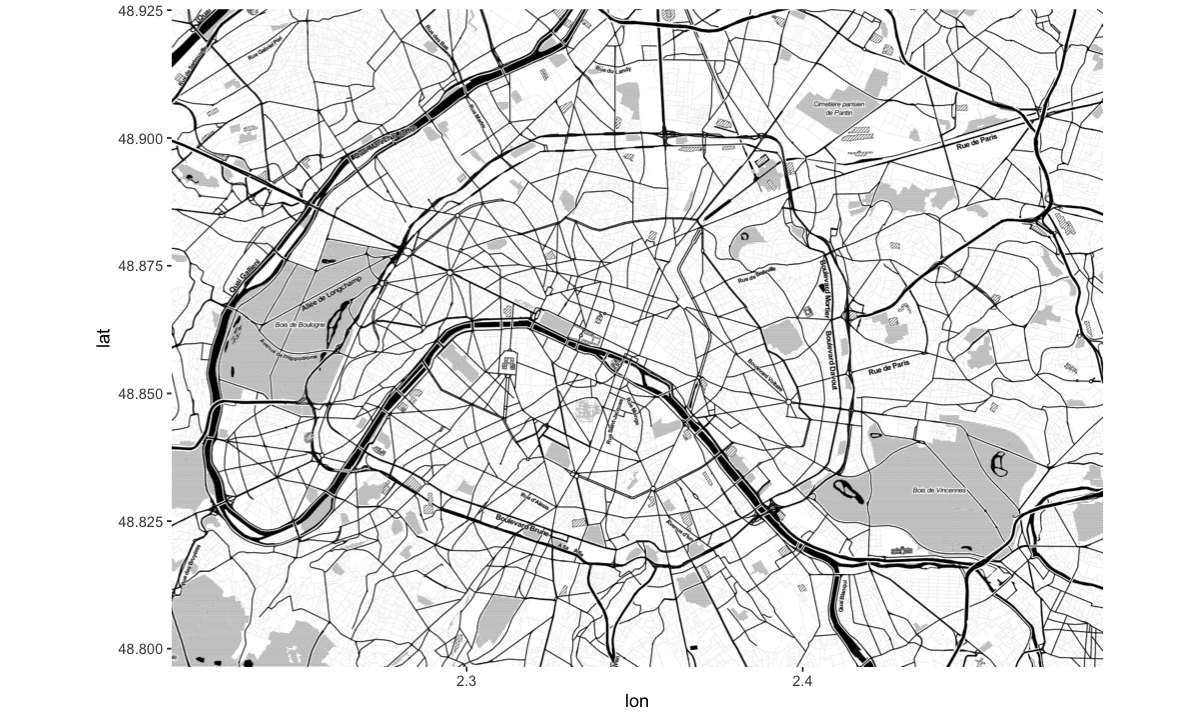

In [215]:
set.seed(423)
res.km5 <- kmeans(clust.data, 5, nstart=10)

fig(10,6)
#qmplot(long, lat, data=bikes.pca, col=as.factor(res.km5$cluster), source='stamen', maptype='toner', mapcolor='bw') +
#    labs(color='Cluster')

mapMargin <- 0.01
lowerleftlon = min(bikes$long) - mapMargin
lowerleftlat = min(bikes$lat) - mapMargin
upperrightlon = max(bikes$long) + mapMargin
upperrightlat = max(bikes$lat) + mapMargin
myMap <- get_stamenmap(bbox=c(lowerleftlon, lowerleftlat, upperrightlon, upperrightlat), 
                       zoom=13,maptype='toner', color='bw')
#?get_stamenmap
ggmap(myMap)

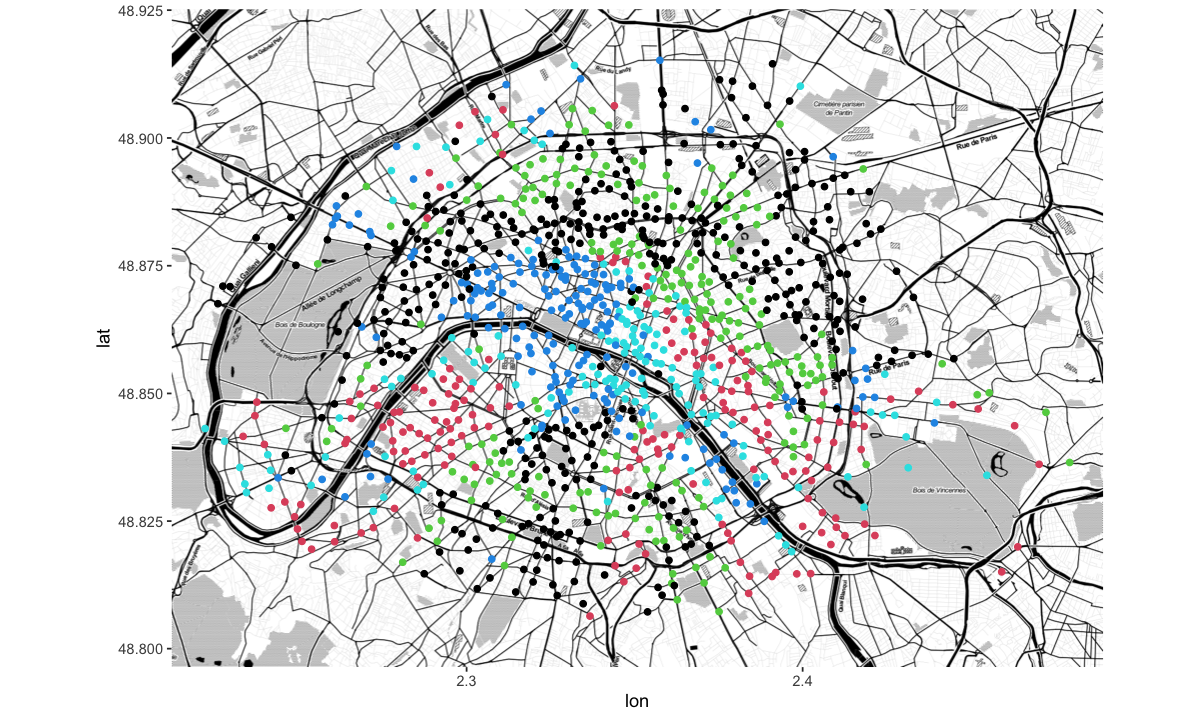

In [222]:
ggmap(myMap) + geom_point(aes(long, lat), data=bikes, col=res.km5$cluster)

In [74]:
K <- 5
p <- 5
pca.var_coord <- as.matrix(res.pca$var$coord[,1:5])
res.km5 <- kmeans(clust.data, 5, nstart=10)
km5centers <- matrix(nrow = 168, ncol = 5)
for (i in 1:5){
    km5centers[, i] <- res.pca$call$centre +
    res.pca$call$ecart.type * res.pca$var$coord[, 1:p] %*% (as.matrix(res.km5$centers[i, ], ncol = 1) / sqrt(res.pca$eig[1:p, 1])) # coord. in the orig. space
}

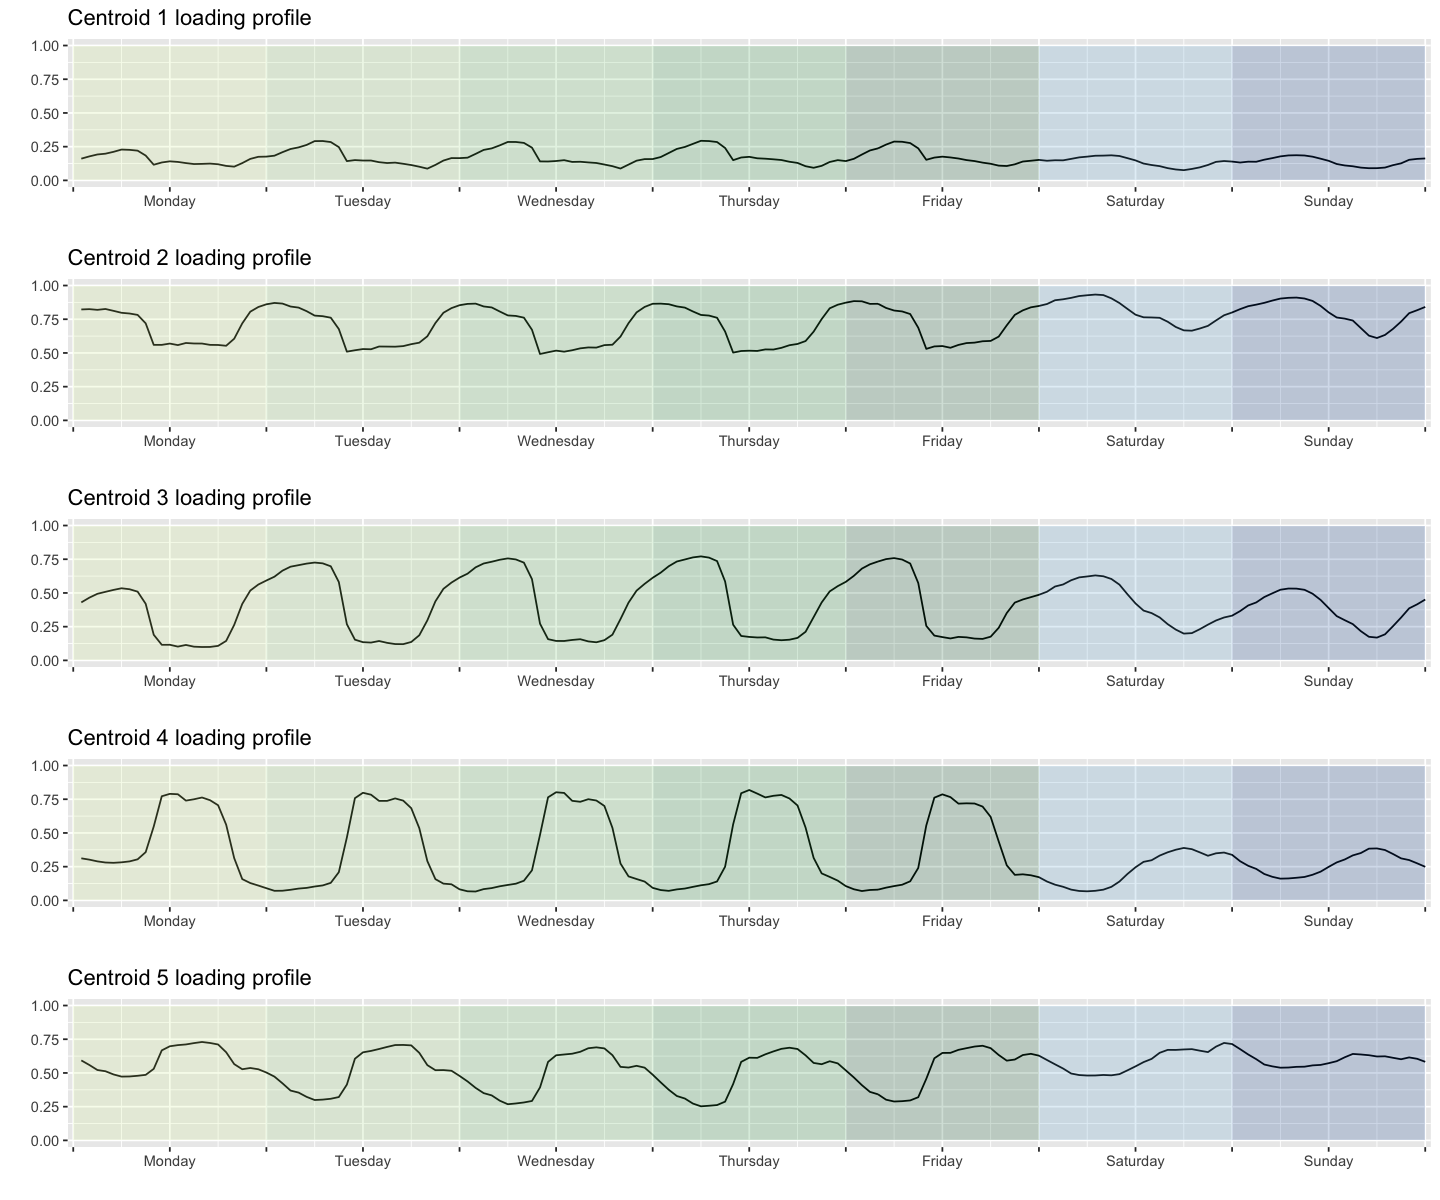

In [252]:
day_lab <- rep('', 15)
day_lab[2*c(1:7)] <- days
plot_center <- function(centers, i) {
    ggplot() + geom_line(aes(t, centers[,i])) + labs(y='', title=sprintf('Centroid %d loading profile', i)) + 
        scale_y_continuous(name='', limits=c(0, 1)) + 
        scale_x_continuous(name='', limits=c(0, 168), breaks=12*c(0:14), labels=day_lab) +
        coord_cartesian(xlim=c(7, 161), ylim=c(0,1)) +
        #annotate('segment', x=24*c(0:7), xend=24*c(0:7), y=rep(0,8), yend=rep(1,8), linetype=2) + 
        annotate('rect', xmin = 24*c(0:6), xmax = 24*c(1:7), ymin = rep(0,7), ymax = rep(1,7), 
                 fill=daycolors, alpha = .2)
        
}

options(repr.plot.width = 12, repr.plot.height = 10)
p1 <- plot_center(km5centers, 1)
p2 <- plot_center(km5centers, 2)
p3 <- plot_center(km5centers, 3)
p4 <- plot_center(km5centers, 4)
p5 <- plot_center(km5centers, 5)
grid.arrange(p1,p2,p3,p4,p5, ncol=1)

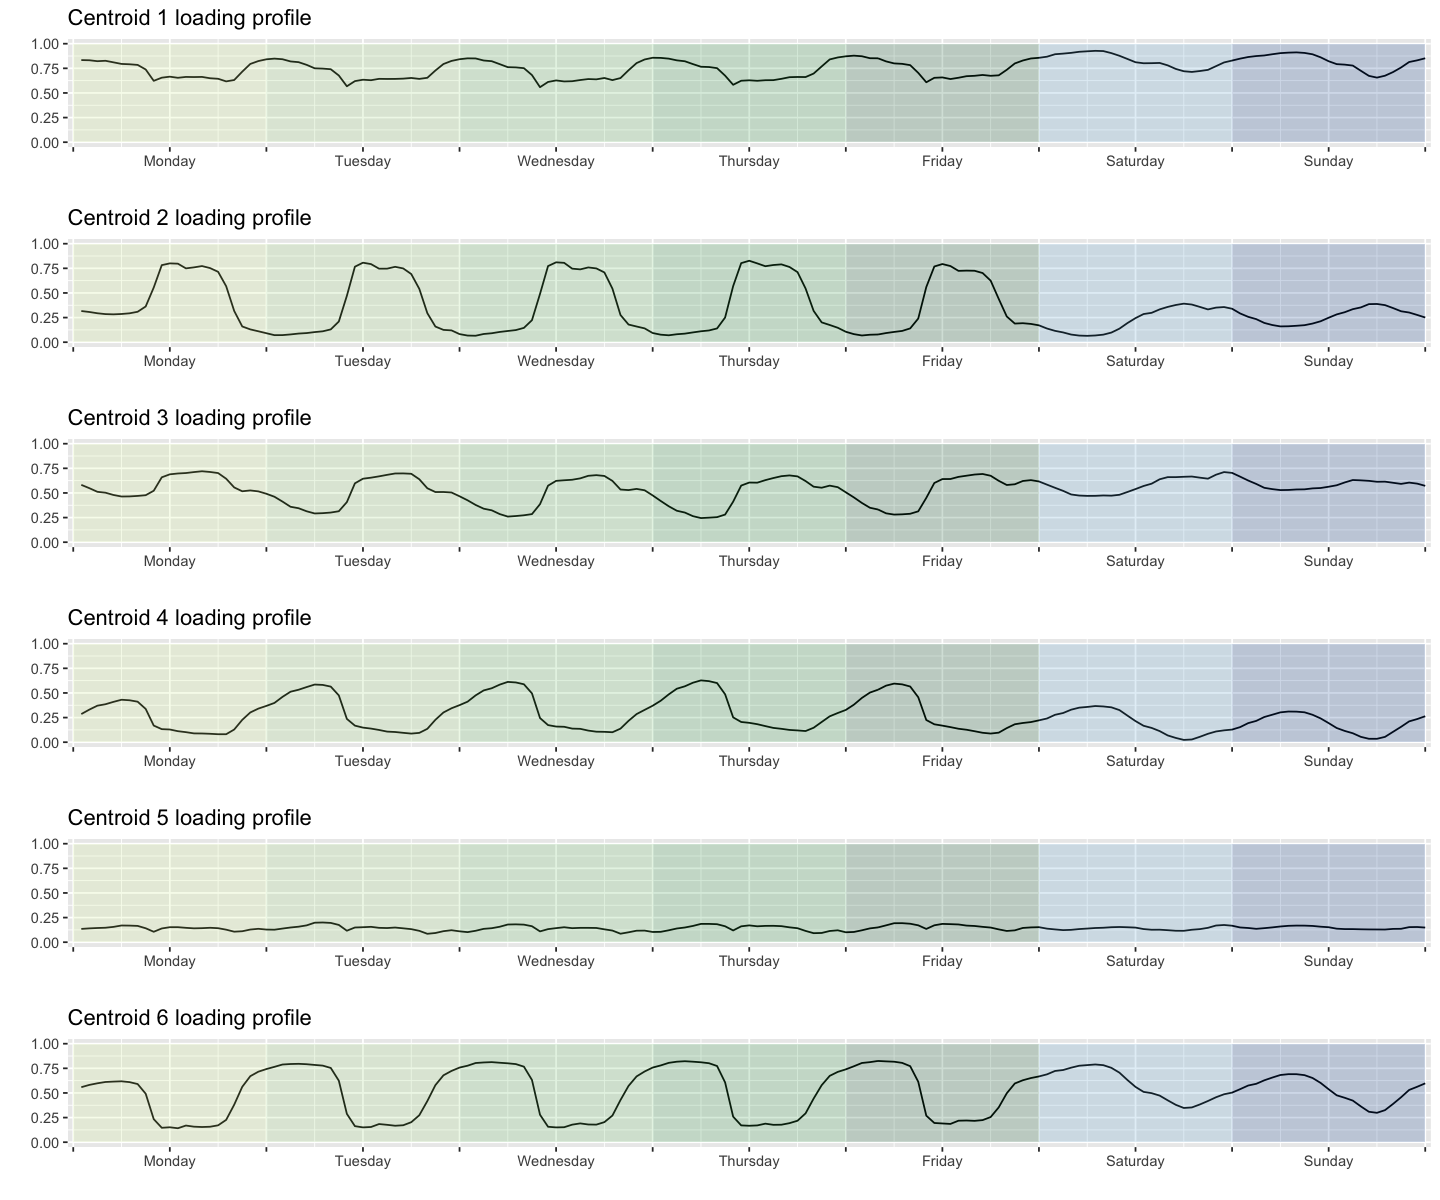

In [253]:
K <- 6
p <- 5
pca.var_coord <- as.matrix(res.pca$var$coord[,1:5])
res.km <- kmeans(clust.data, K, nstart=10)
kmcenters <- matrix(nrow = 168, ncol = K)
for (i in 1:K){
    kmcenters[, i] <- res.pca$call$centre +
    res.pca$call$ecart.type * res.pca$var$coord[, 1:p] %*% (as.matrix(res.km$centers[i, ], ncol = 1) / sqrt(res.pca$eig[1:p, 1])) # coord. in the orig. space
}

options(repr.plot.width = 12, repr.plot.height = 10)
p1 <- plot_center(kmcenters, 1)
p2 <- plot_center(kmcenters, 2)
p3 <- plot_center(kmcenters, 3)
p4 <- plot_center(kmcenters, 4)
p5 <- plot_center(kmcenters, 5)
p6 <- plot_center(kmcenters, 6)
#grid.arrange(p1,p2,p3, ncol=1)
#grid.arrange(p1,p2,p3,p4, ncol=1)
grid.arrange(p1,p2,p3,p4,p5,p6, ncol=1)

In [338]:
set.seed(423)
km.full <- kmeans(bikes %>% select(T1:T168), 6, nstart=10)
km.full$centers <- km.full$centers[c(5,4,2,6,1,3),]
km.full$cluster <- as.factor(km.full$cluster)
levels(km.full$cluster) <- list('1'='5', '2'='4', '3'='2', '4'='6', '5'='1', '6'='3')

Using zoom = 12...



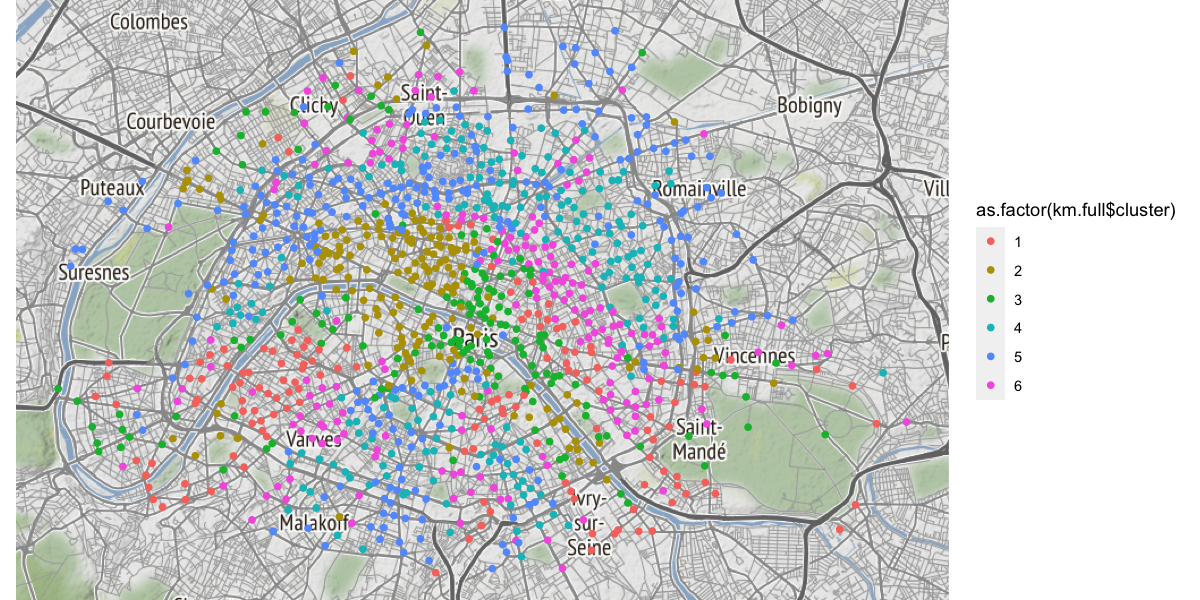

In [339]:
fig(10,5)
qmplot(long, lat, data=bikes, col=as.factor(km.full$cluster))

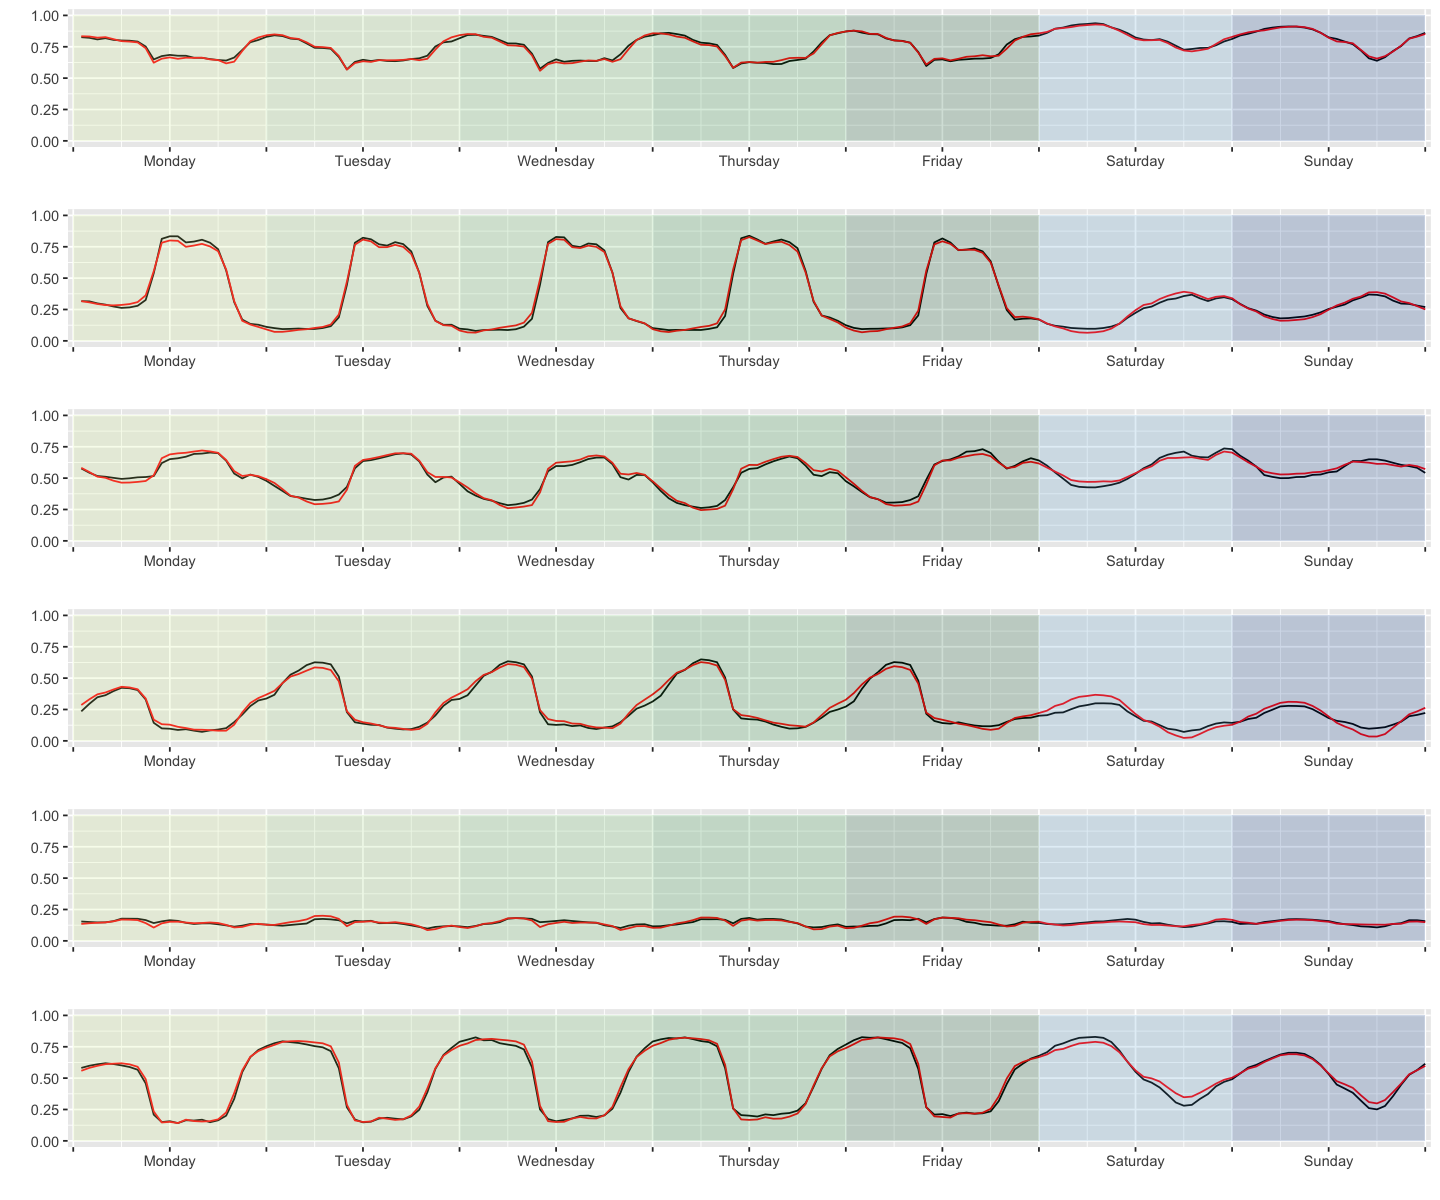

In [340]:
compare_full_v_pca <- function(centers.full, centers.pca, i) {
    ggplot() + geom_line(aes(t, centers.full[i,])) + labs(y='') +
        geom_line(aes(t, centers.pca[,i]), color='red') + 
        scale_y_continuous(name='', limits=c(0, 1)) + 
        scale_x_continuous(name='', limits=c(0, 168), breaks=12*c(0:14), labels=day_lab) +
        coord_cartesian(xlim=c(7, 161), ylim=c(0,1)) +
        annotate('rect', xmin = 24*c(0:6), xmax = 24*c(1:7), ymin = rep(0,7), ymax = rep(1,7), 
                 fill=daycolors, alpha = .2)
        
}

fig(12,10)
p1 <- compare_full_v_pca(km.full$centers, kmcenters, 1)
p2 <- compare_full_v_pca(km.full$centers, kmcenters, 2)
p3 <- compare_full_v_pca(km.full$centers, kmcenters, 3)
p4 <- compare_full_v_pca(km.full$centers, kmcenters, 4)
p5 <- compare_full_v_pca(km.full$centers, kmcenters, 5)
p6 <- compare_full_v_pca(km.full$centers, kmcenters, 6)
grid.arrange(p1,p2,p3,p4,p5,p6, ncol=1)
#km.full$centers[1,]

In [341]:
confusionMatrix(reference=as.factor(res.km$cluster), 
                data=as.factor(km.full$cluster), 
                positive=NULL, dnn=c('PCA clustering', 'Raw data clustering'))

Confusion Matrix and Statistics

              Raw data clustering
PCA clustering   1   2   3   4   5   6
             1 147   0   0   0   0   0
             2   0 185   0   0   0   0
             3   2   2 149   2   0   0
             4   0   1   0 207   5   0
             5   0   2   0   2 292   0
             6   0   0   0   7   0 186

Overall Statistics
                                          
               Accuracy : 0.9807          
                 95% CI : (0.9711, 0.9877)
    No Information Rate : 0.2498          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9765          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4 Class: 5 Class: 6
Sensitivity            0.9866   0.9737   1.0000   0.9495   0.9832   1.0000
Specificity            1.0000   1.0000   0.9942   0.9938   0.9955   0.9930
Pos P

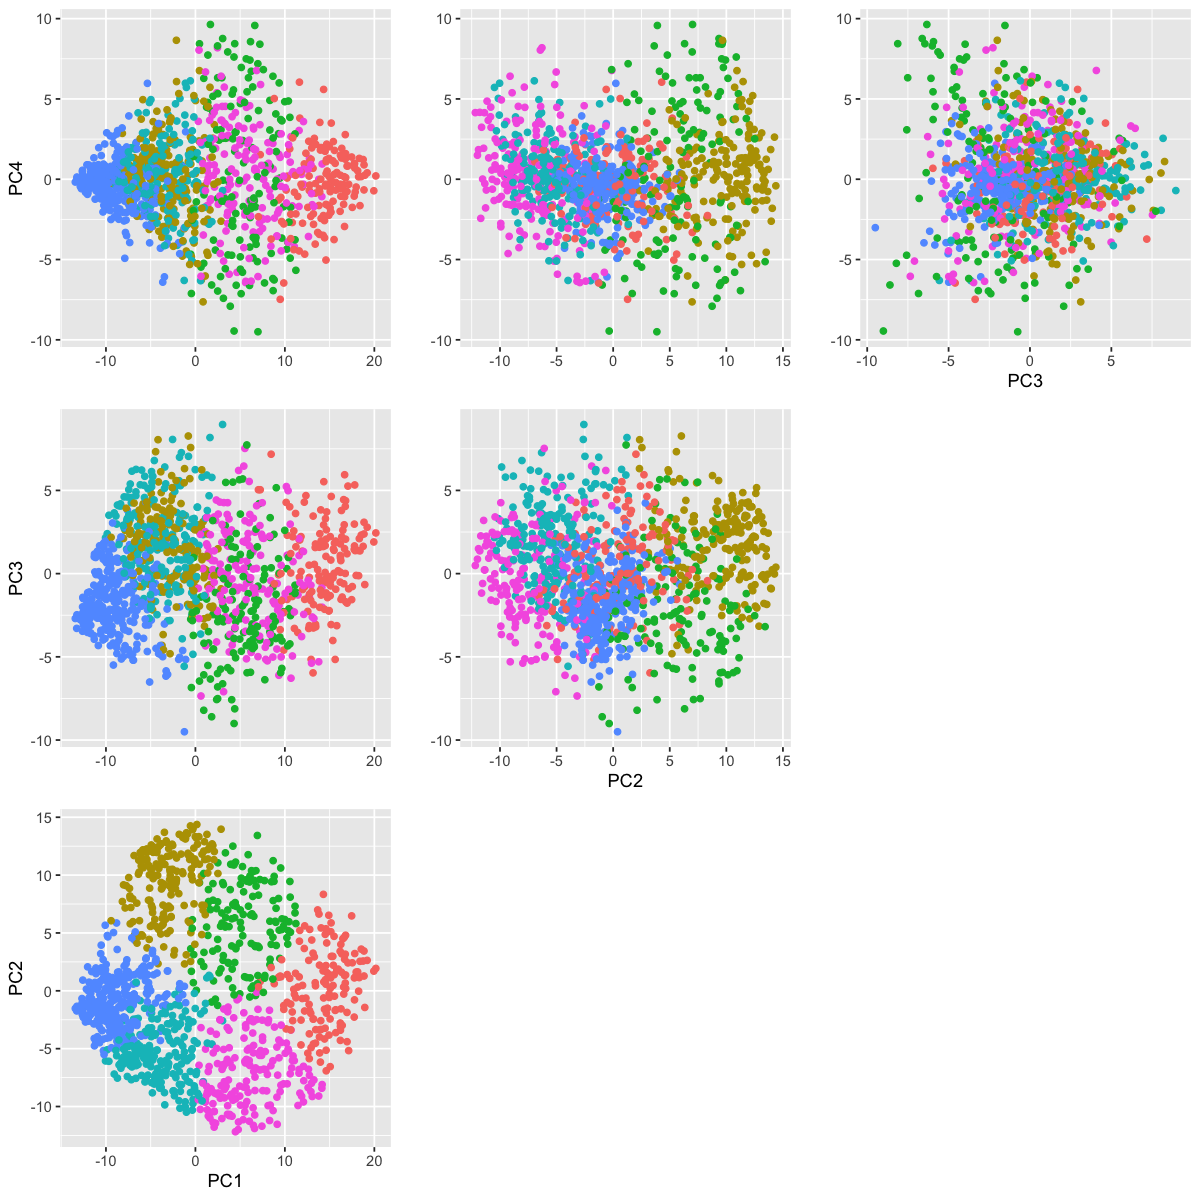

In [289]:
options(repr.plot.width = 10, repr.plot.height = 10)

g <- ggplot(bikes.pca, aes(col=as.factor(res.km$cluster))) + 
    #guides(color='legend') +
    theme(legend.position = c(10, 0))

p12 <- g + geom_point(aes(PC1, PC2)) +
    labs(x='PC1', y='PC2')

g <- ggplot(bikes.pca, aes(col=as.factor(res.km$cluster))) + 
    guides(color='none')

p13 <- g + geom_point(aes(PC1, PC3)) +
    labs(x='', y='PC3')
p14 <- g + geom_point(aes(PC1, PC4)) +
    labs(x='', y='PC4')
p23 <- g + geom_point(aes(PC2, PC3)) +
    labs(x='PC2', y='')
p24 <- g + geom_point(aes(PC2, PC4)) +
    labs(x='', y='')
p34 <- g + geom_point(aes(PC3, PC4)) +
    labs(x='PC3', y='')

lay <- rbind(c(3, 5,6),
             c(2, 4,NA),
             c(1,NA,NA))
grid.arrange(p12, p13, p14, p23,p24,p34, layout_matrix = lay)

In [159]:
mod.gm = Mclust(bikes.pca %>% select(PC1:PC5), G=4)
summary(mod.gm)

---------------------------------------------------- 
Gaussian finite mixture model fitted by EM algorithm 
---------------------------------------------------- 

Mclust VVE (ellipsoidal, equal orientation) model with 4 components: 

 log-likelihood    n df       BIC       ICL
      -15753.28 1189 53 -31881.85 -32068.87

Clustering table:
  1   2   3   4 
241 611 137 200 

In [160]:
str(mod.gm)

List of 16
 $ call          : language Mclust(data = bikes.pca %>% select(PC1:PC5), G = 4)
 $ data          : num [1:1189, 1:5] -3.047 6.479 3.12 0.659 4.443 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:5] "PC1" "PC2" "PC3" "PC4" ...
 $ modelName     : chr "VVE"
 $ n             : int 1189
 $ d             : int 5
 $ G             : int 4
 $ BIC           : 'mclustBIC' num [1, 1:14] -32957 -32593 -32674 -31966 -32564 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr "4"
  .. ..$ : chr [1:14] "EII" "VII" "EEI" "VEI" ...
  ..- attr(*, "G")= num 4
  ..- attr(*, "modelNames")= chr [1:14] "EII" "VII" "EEI" "VEI" ...
  ..- attr(*, "control")=List of 4
  .. ..$ eps     : num 2.22e-16
  .. ..$ tol     : num [1:2] 1.00e-05 1.49e-08
  .. ..$ itmax   : int [1:2] 2147483647 2147483647
  .. ..$ equalPro: logi FALSE
  ..- attr(*, "initialization")=List of 3
  .. ..$ hcPairs: 'hc' num [1:2, 1:1188] 419 598 419 692 419 ...
  .. .. ..- attr(*, "initialPartition")= num 

In [162]:
mod.gm$classification

[1] 1 1 2 2 2 2 2 1 2 2 1 2 3 2 3 4 2 1 2 2 2 3 3 2 2 1 4 2 4 3 4 4 2 2 2 2 4
  [38] 2 2 2 2 2 4 2 1 1 2 2 2 2 1 2 2 2 2 3 2 1 1 2 1 3 2 3 2 4 2 4 1 4 3 4 2 1
  [75] 4 3 2 4 1 4 2 1 2 2 4 2 1 2 4 4 4 4 2 1 2 2 3 1 4 2 2 3 2 3 1 1 4 2 4 2 3
 [112] 2 2 2 3 2 2 2 1 2 2 1 2 2 2 2 4 1 2 2 2 2 2 2 2 3 1 4 3 1 1 2 2 1 2 3 2 2
 [149] 3 4 2 1 4 2 1 4 2 2 2 1 1 4 1 2 2 4 2 1 4 1 4 2 4 2 1 1 4 3 2 2 3 2 1 4 2
 [186] 2 2 2 1 2 4 2 2 2 2 2 2 4 1 3 1 1 4 1 2 2 2 2 4 1 2 4 4 3 3 4 2 2 2 2 2 2
 [223] 2 4 1 2 1 2 2 2 2 2 1 3 2 4 2 2 2 2 2 4 3 2 2 2 1 2 2 2 4 2 2 2 4 3 2 2 2
 [260] 3 3 2 2 4 2 2 3 4 4 2 4 2 4 3 1 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 1 2 2 2 2
 [297] 2 4 2 2 3 3 1 3 4 2 4 4 2 2 2 2 2 2 1 3 1 1 2 2 2 2 2 3 4 4 4 1 2 1 2 1 3
 [334] 2 1 2 2 2 2 2 2 1 2 2 1 1 3 1 2 2 3 2 2 1 1 4 3 3 1 2 1 1 2 1 2 2 2 2 2 4
 [371] 2 4 3 4 3 3 2 3 3 1 4 2 3 4 1 3 2 1 3 4 2 3 2 4 1 2 1 2 1 1 1 2 2 2 3 2 2
 [408] 3 3 1 1 2 2 2 3 2 2 1 4 1 2 2 3 2 2 2 1 3 1 2 2 2 1 2 2 4 4 4 2 1 2 1 4 4
 [445] 2 1 1 4 4 1 3 2 1 3 4 2 1 2 2 2 4 2 4 2 1 2 3 2 4 2 2 2 4 4 3 2 2 2 4 4 2
 [482] 4 3 2 2 2 2 1 1 3 2 2 3 2 4 2 3 4 2 4 3 2 1 4 2 1 2 2 4 2 2 4 2 4 2 3 2 3
 [519] 2 1 2 4 1 4 1 3 2 4 4 2 1 2 4 4 1 2 2 4 3 2 1 2 2 2 2 1 2 2 2 2 4 2 3 2 2
 [556] 1 3 3 2 2 2 1 2 1 2 2 1 3 1 1 1 2 4 2 1 1 2 3 2 4 2 3 2 2 2 2 4 1 1 2 4 2
 [593] 2 2 1 2 2 4 1 2 3 2 1 1 1 2 2 4 4 2 3 4 1 1 2 2 4 1 2 2 1 4 3 2 3 2 2 4 3
 [630] 1 2 1 2 2 1 1 1 2 1 3 3 2 1 1 4 3 2 2 2 2 1 1 3 4 4 1 2 2 3 2 1 1 2 3 3 4
 [667] 3 2 1 2 2 2 1 2 4 2 4 2 4 2 2 2 4 1 2 2 1 4 2 4 2 4 1 2 2 3 4 1 3 2 2 2 4
 [704] 2 1 2 2 2 1 2 4 2 2 2 4 1 1 3 2 1 1 1 4 1 4 2 2 2 2 2 2 3 2 1 2 2 1 1 3 2
 [741] 3 1 2 1 2 2 2 4 1 2 2 3 2 2 3 4 4 2 3 4 4 4 2 1 1 3 2 4 1 4 2 2 2 2 2 2 3
 [778] 1 1 2 2 1 2 1 1 1 3 4 4 2 2 2 2 3 2 4 2 2 2 1 3 2 2 2 2 2 2 1 3 4 2 2 2 4
 [815] 4 2 4 4 2 3 1 2 2 3 1 3 2 1 2 3 3 3 2 2 3 2 1 2 4 2 1 2 2 4 2 2 4 2 2 2 2
 [852] 2 2 2 2 2 2 2 3 2 2 2 2 4 2 2 2 2 2 2 3 2 2 2 2 2 2 4 3 2 4 4 1 2 2 2 2 2
 [889] 2 1 2 2 2 2 3 1 2 2 2 2 1 1 4 2 4 2 2 2 2 2 2 3 2 1 1 1 2 2 3 2 1 2 2 4 2
 [926] 4 2 4 1 1 2 2 2 1 3 2 2 3 2 1 2 4 3 2 2 1 2 1 2 2 2 2 1 2 2 1 4 3 1 1 4 4
 [963] 2 2 4 2 3 1 2 2 1 1 2 1 1 2 2 2 2 1 1 4 2 4 3 2 1 2 2 2 4 2 2 1 1 2 4 1 2
[1000] 4 4 1 2 4 2 2 2 1 2 1 3 2 2 4 1 4 4 2 1 2 1 2 2 2 2 2 2 4 4 2 4 1 1 3 2 2
[1037] 2 2 2 2 2 2 3 3 1 4 4 2 2 1 2 2 2 2 1 2 4 2 4 3 3 1 1 1 2 2 2 4 3 3 2 1 4
[1074] 1 4 1 2 2 2 1 1 4 2 2 2 2 2 4 2 4 1 1 1 2 1 2 2 2 4 4 2 1 1 2 2 1 2 2 1 2
[1111] 2 2 2 1 3 4 2 2 4 2 4 1 2 4 2 4 3 2 2 4 2 2 4 2 4 2 2 4 3 2 2 2 4 3 2 2 4
[1148] 2 2 2 4 4 2 1 1 1 1 2 2 4 2 2 1 1 4 2 2 2 1 2 4 2 2 2 2 3 2 2 1 2 1 3 2 1
[1185] 1 2 2 2 2

In [157]:
mclust.options("emModelNames")

[1] "EII" "VII" "EEI" "VEI" "EVI" "VVI" "EEE" "VEE" "EVE" "VVE" "EEV" "VEV"
[13] "EVV" "VVV"